In [81]:
import numpy as np
import os
import os.path as p

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid
# from torchvision.io import read_image


from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import seaborn_image as isns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Загружаем и подготавливаем датасет

100.0%


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100.0%

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw

32


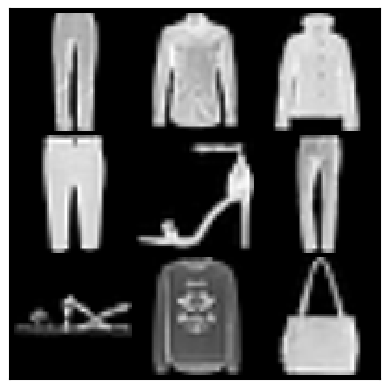

In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
CODING_SIZE = 100

transform = v2.Compose(
    [
        v2.Resize(IMAGE_SIZE),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.FashionMNIST(
    root="./",
    train=False,
    download=True,
    transform=transform,
)

data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

data = next(iter(data_loader))
print(data[1].size()[0])

imgs_grid = make_grid([data[0][i] for i in range(9)], nrow=3)
img = torchvision.transforms.ToPILImage()(imgs_grid)
fig, axs = plt.subplots()
axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.imshow(img)

# Генератор

In [53]:
class Generator(nn.Module):
    def __init__(self, coding_sz):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(coding_sz, 1024, 4, 1, 0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.net(input)

netG = Generator(CODING_SIZE).to(device)

In [54]:
print(summary(netG, (100, 1, 1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,416
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           2,049
             Tanh-14            [-1, 1,

# Дискриминатор

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            nn.Conv2d(1024, 1, 4, 1, 0),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.net(input)

netD = Discriminator().to(device)

In [56]:
print(summary(netD, (1, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           2,176
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,544
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
            Conv2d-6            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 4, 4]       8,389,632
      BatchNorm2d-10           [-1, 1024, 4, 4]           2,048
        LeakyReLU-11           [-1, 1024, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]          16,385
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 11,033,985
Trainable para

# Инициализация весов

In [57]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BarchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [58]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

# Обучение модели

In [59]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

def make_labels(batch_size):
    real_labels = torch.full(
        (batch_size,),
        1.,
        dtype=torch.float32,
        device=device
    )
    
    fake_labels = torch.full(
        (batch_size,),
        0,
        dtype=torch.float32,
        device=device
    )
    return real_labels, fake_labels

G_losses = []
D_losses = []
D_real = []
D_fake = []

z = torch.randn((BATCH_SIZE, CODING_SIZE)).view(-1, CODING_SIZE, 1, 1).to(device)
test_out_images = []


In [60]:
N_EPOCHS = 10
num_of_batches = len(data_loader)

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch}")
    for i, batch in enumerate(data_loader):
        if i % 100 == 0 or i == num_of_batches - 1:
            real_labels, fake_labels = make_labels(batch[0].size()[0])
            print(f"batch {i + 1 if i == 0 or i == num_of_batches - 1 else i} of {num_of_batches}")
            
        # обучение Дискриминатора на реальных данных
        netD.zero_grad()
        real_images = batch[0].to(device) # batch[1] contains labels
        output = netD(real_images).view(-1)
        errD_real = criterion(output, real_labels)
        D_x = output.mean().item()
        
        # обучение Дискриминатора на сгенерированных генератором данных
        noise = torch.randn((fake_labels.size()[0], CODING_SIZE)).view(-1, CODING_SIZE, 1, 1).to(device)
        fake_images = netG(noise)
        output = netD(fake_images).view(-1)
        errD_fake = criterion(output, fake_labels)
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        errD.backward(retain_graph=True)
        optimizerD.step()

        # обучение Генератора
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_real.append(D_x)
        D_fake.append(D_G_z2)

    with torch.no_grad():
        test_images = netG(z).to("cpu").detach()
    test_images = make_grid([test_images[i] for i in range(32)], nrow=4)
    test_out_images.append(torchvision.transforms.ToPILImage()(test_images))


Epoch: 0
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 1
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 2
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 3
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 4
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 5
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 6
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 7
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 8
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313
Epoch: 9
batch 1 of 313
batch 100 of 313
batch 200 of 313
batch 300 of 313
batch 313 of 313


In [68]:
if not p.exists("./weights/"):
    os.mkdir("./weights")
    torch.save(netD.state_dict(), "./weights/Discriminator.pt")
    torch.save(netG.state_dict(), "./weights/Generator.pt")
else:
    netG = Generator(CODING_SIZE).to(device) 
    netD = Discriminator().to(device) 
    netG.load_state_dict(torch.load("./weights/Generator.pt", weights_only=True))
    netD.load_state_dict(torch.load("./weights/Discriminator.pt", weights_only=True))


# Визуализация результатов

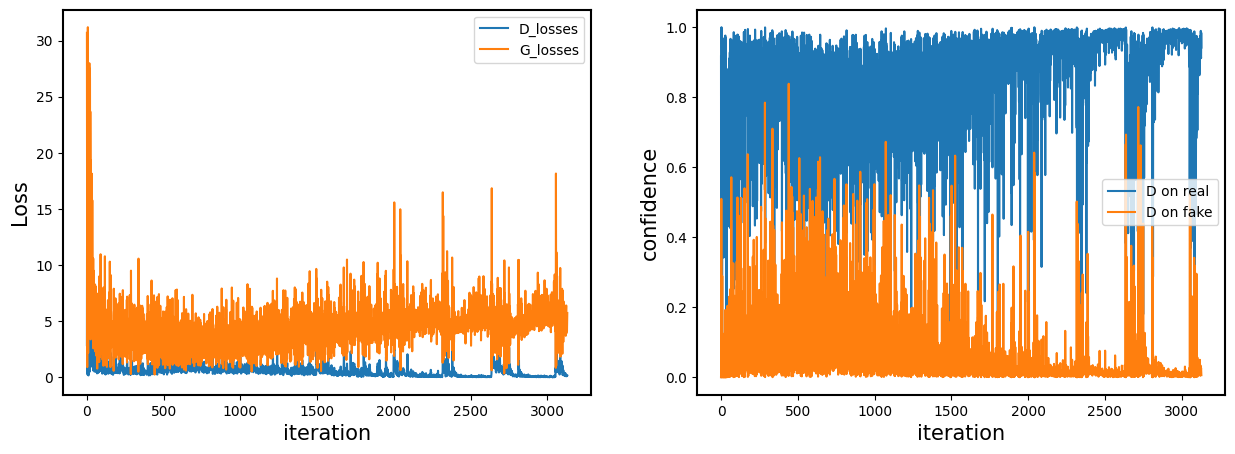

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].plot(range(len(D_losses)), D_losses, label="D_losses")
axs[0].plot(range(len(G_losses)), G_losses, label="G_losses")
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(len(D_real)), D_real, label="D on real")
axs[1].plot(range(len(D_fake)), D_fake, label="D on fake")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("confidence")
axs[1].legend()


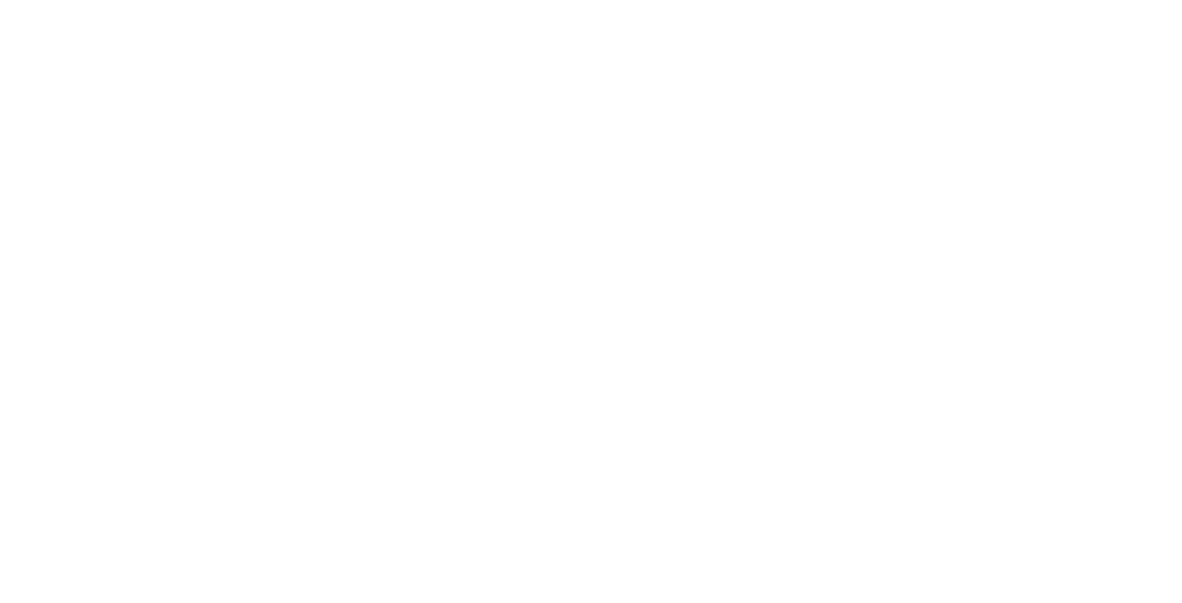

In [67]:
netG.eval()
test_out_images = []
fig, ax = plt.subplots(figsize=(15,10))
ax.axis("off")
for i in range(10):
    imgs = netG(torch.randn((BATCH_SIZE, CODING_SIZE)).view(BATCH_SIZE, CODING_SIZE, 1, 1).to(device))
    test_images = make_grid(imgs, nrow=8)
    im = torchvision.transforms.ToPILImage()(test_images)
    img = ax.imshow(im, animated=True)
    test_out_images.append([img])

ani = animation.ArtistAnimation(fig, test_out_images, interval=1000, repeat_delay=1000)
HTML(ani.to_jshtml())